<a href="https://colab.research.google.com/github/lingchm/datascience-projects/blob/master/P3_Amazon_Prime_Video_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Prime Video Prediction

Problem Statement:

There are about 4000+ rows and 16 columns. Cvt_per_day is a measure on how much a movie is consumed by the audiences per day. Higher number means the movie is more popular on our platform

Goal:
* Build a prediction model to predict whether a movie is going to perform well on our platform (cvt_per_day) based on the information in the dataset
* We are curious to hear about (1) how you dealt with missing values, (2) how you selected, transformed, or engineered new features, (3) the type of model used and why, and (4) any particular insights or other thoughts you have on this dataset



Dataset:
```
Video_id: a unique id for a movie
cvt_per_day: cumulated view time per day
weighted_categorical_position: avg vertical positions on the home page that the movie was placed
genres: genres of the movie
release_year: the year the movie was released
imdb_votes: the number of votes on IMDB, typically higher the votes the better
budget: budget of the movie production, typically the higher the better
boxoffice: gross box office in US as updated on IMDB, typically the higher the better
imdb_rating: ratings on IMDB
duration_in_mins: content length in minutes
mpaa: MPAA ratings
awards: TVPG ratings
import_id: content partners
metacritic_Score: metacritic score on IMDB page, typically the higher the better
star_category: a score to measure how popular the actor/actress are associated with the movie
```



## Content
* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Feature Selection](#Part-4:-Feature-Selection)

# Part 0 Load packages, load data


In [1]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TVdata.txt to TVdata (2).txt


In [ ]:
# Another way to load data
import pandas as pd
file_id='1M1uoLuILH4Gs-hObvMad7mTbJtUGONdQ'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
my_data = pd.read_csv(csv_url)
my_data.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


In [ ]:
TV=pd.read_table('TVdata.txt',header=0,sep=',',lineterminator='\n')
print(TV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  import_id  release_year  \
0                            3  lionsgate          2013   
1                            3  lionsgate          2013   
2                            3      other          2012   
3                            4  lionsgate          2008   
4                            3  lionsgate          2013   

                                          genres  imdb_votes    budget  \
0                          Action,Thriller,Drama       69614  15000000   
1                          Comedy,Crime,Thriller       46705  15000000   
2                                    Crime,Drama      197596  260000

# Part 1: Data Exploration

## 1.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [ ]:
if TV['video_id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


## 1.2 Understand numerical features

### 1.2.1 Overview

In [ ]:
TV.info()
print(TV.drop(columns=['video_id','release_year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
(TV==0).sum(axis=0)/TV.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64

### 1.2.2 cvt_per_day feature

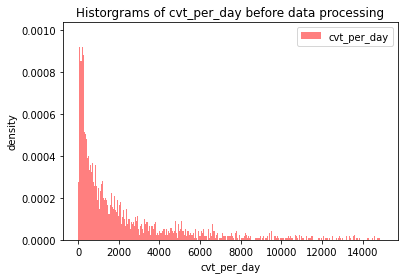

In [ ]:
plt.hist(TV['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True,alpha=0.5)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### 1.2.3 Correlation among numerical features

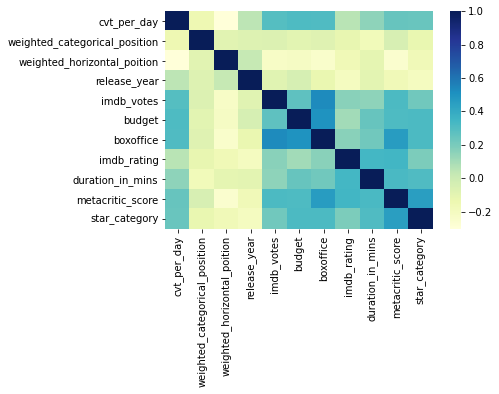

In [ ]:
corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [ ]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


## 1.3 Understand categorical features

### 1.3.1 Distribution of standard categorical features

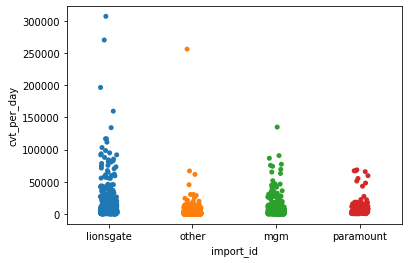

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


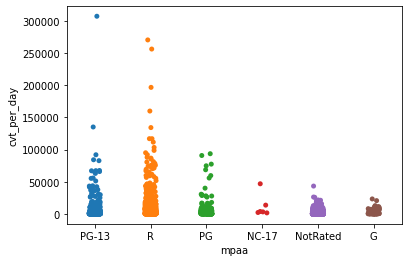

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


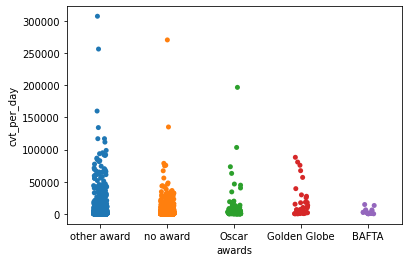

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


In [ ]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['import_id'].value_counts())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['mpaa'].value_counts())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print(TV['awards'].value_counts())

After very basic Exploratory Data Analysis, we have to do some data cleaning and data preprocessing.
We need three steps to finish  this.
First, we need to encode the categorical feature.
Second, we need to impute the missing value for both numeric and categorical feature.
Third, we need to scale out feature, which can be better for our models' performance.



### 1.3.2 Distribution of splited genres

Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

Action                    739
Adult                       3
Adventure                 363
Animation                 129
Anime                      11
Comedy                   1184
Crime                     437
Documentary               671
Drama                    1677
Fantasy                   243
Foreign/International      64
Holiday                     1
Horror                    762
Independent               393
Kids & Family             280
LGBT                        2
Lifestyle                   7
Music                     171
Musicals                   68
Mystery                   375
Reality                     9
Romance                   591
Sci-Fi                    363
Sport                      77
Thriller                  879
War                       102
Western                   102
dtype: int64


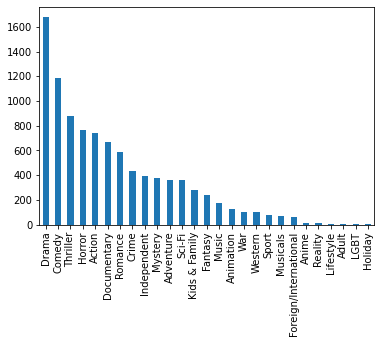

In [ ]:
# generes explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

### 1.3.3 Distribution of release_year

The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range.

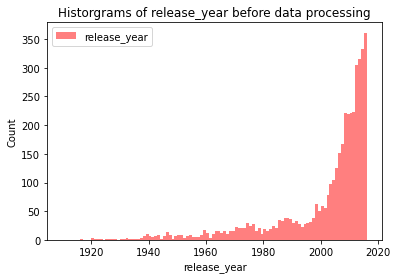

In [ ]:
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()


# Part 2: Feature Preprocessing

## 2.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 
1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.
2. The release_year is binned into 10 buckets based on the year range between 1917 and 2017.

In [ ]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [ ]:
# Convert 'genres' into dummy variables
d_genres=TV['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [ ]:
TV['release_year'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

0.100   1974.000
0.200   1991.000
0.300   2001.000
0.400   2006.000
0.500   2008.000
0.600   2010.000
0.700   2012.000
0.800   2013.000
0.900   2014.000
Name: release_year, dtype: float64

In [ ]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [ ]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null

temp_tv=TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)

newTV = pd.concat([temp_tv, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print(newTV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462        6.500   
1                            3       46705  15000000    3301046        6.500   
2                            3      197596  26000000   37397291        7.300   
3                            4      356339  15000000   15700000        7.600   
4                            3       46720  27220000    8551228        6.400   

   duration_in_mins  metacritic_score  star_category  lionsgate  mgm  other  \
0           112.301                51          1.710          1    0      0   
1     

## 2.2 Missing data

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

Right Now we have to deal with the missing data. According to the data info, there is no Null value in our dataset.
That's good, but we have to be catious, cause zero value can be a very good candidate for missing data. 
So we have the check the ratio of zero value in our numeric feature

In [ ]:
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)
print(newTV.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     3882 non-null   float64
 5   budget                         1772 non-null   float64
 6   boxoffice                      1032 non-null   float64
 7   imdb_rating                    3882 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               1214 non-null   float64
 10  star_category                  2380 non-null   float64
 11  lionsgate                      4226 non-null   int64  
 12  mgm                            4226 non-null   i

In [ ]:
print(newTV.isnull().sum()/newTV.shape[0])

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
star_category                   0.437
lionsgate                       0.000
mgm                             0.000
other                           0.000
paramount                       0.000
G                               0.000
NC-17                           0.000
NotRated                        0.000
PG                              0.000
PG-13                           0.000
R                               0.000
BAFTA                           0.000
Golden Globe                    0.000
Oscar                           0.000
no award                        0.000
other award                     0.000
Action      

Filling missing data with mean value

In [ ]:
newTV1=newTV.copy()
newTV1['boxoffice']=newTV1['boxoffice'].fillna(newTV1['boxoffice'].mean())
newTV1['metacritic_score']=newTV1['metacritic_score'].fillna(newTV1['metacritic_score'].mean())
newTV1['star_category']=newTV1['star_category'].fillna(newTV1['star_category'].mean())
newTV1['imdb_votes']=newTV1['imdb_votes'].fillna(newTV1['imdb_votes'].mean())
newTV1['imdb_rating']=newTV1['imdb_rating'].fillna(newTV1['imdb_rating'].mean())
newTV1['budget']=newTV1['budget'].fillna(newTV1['budget'].mean())
print(newTV1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   float64
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  lionsgate                      4226 non-null   int64  
 12  mgm                            4226 non-null   i

There are two most common used scaling method: normalization and standardscaler
If there are no specific requirement for the range of output, we choose to use standardscaler

## 2.3 Feature scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [ ]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV1.copy()

sc_scale = preprocessing.StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])
newTV_sc.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,0.033,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,3.434,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,2.102,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,-0.063,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,3.029,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# MinMax scaling
newTV_mm = newTV.copy()
mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

In [ ]:
# Robust scaling
newTV_rs = newTV.copy()
rs_scale = preprocessing.RobustScaler().fit(newTV_mm[scale_lst])
newTV_rs[scale_lst] = rs_scale.transform(newTV_rs[scale_lst])

# Part 3: Model Training

In [ ]:
train, test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

### 3.1 Lasso linear regression

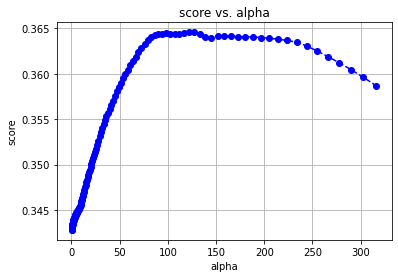

The optimaized alpha and score of Lasso linear is: 


(None, 122.06107238906554, 0.36457853302954246)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [ ]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


Lasso(alpha=122.06107238906554, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 3.2 Ridge linear regression

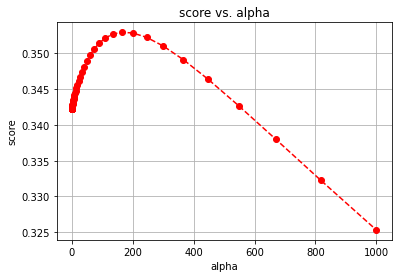

The optimaized alpha and score of Ridge linear is: 


(None, 163.97026580002054, 0.35296043098491625)

In [ ]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [ ]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=163.97026580002054, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

##3.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=2,max_features='sqrt',n_jobs=-1)
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

{'mean_fit_time': array([0.44522071, 0.43030982, 0.44718399, 0.45068169, 0.43231883,
       0.43032856, 0.44098229, 0.42902608, 0.44172001, 0.45503554,
       0.46336203, 0.42371058, 0.42419353, 0.44604545, 0.44566483,
       0.43520942, 0.43288932, 0.481247  , 0.52993021, 0.5525959 ,
       0.52929692, 0.54643102, 0.52622743, 0.52633553, 0.54832478,
       0.54465928, 0.52746944, 0.53930669, 0.54354968, 0.54680829,
       0.54608908, 0.54943547, 0.50082088, 0.44823618, 0.427846  ,
       0.44848247, 0.52542629, 0.53045449, 0.54016829, 0.52992973,
       0.54741411, 0.53124843, 0.5500742 , 0.52491755, 0.4833909 ,
       0.45914788, 0.47725272, 0.46934571, 0.50879207, 0.49703441,
       0.52819963, 0.56054983, 0.53884978, 0.56384449, 0.55339422,
       0.47323198, 0.48034463, 0.48698015, 0.50865903, 0.54739799,
       0.52673483, 0.54594069, 0.59082375, 0.642274  , 0.63323903,
       0.63206396, 0.5268055 , 0.53231163, 0.51741571, 0.54563684,
       0.52354922, 0.51604991, 0.52330394, 0

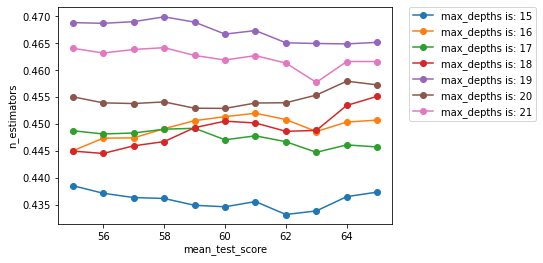

the best parameter for max_depth is: 19
the best parameter for n_estimators is: 58


In [ ]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('n_estimators')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



# Part 4: Model Evaluation

## 4.1: Evaluate all models

In [ ]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [ ]:
#For lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.09954927178753703
Mean square error of lasso:  238953191.99910036
Root mean squared error of lasso: 15458.110880670392


In [ ]:
#for ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.11371374943726809
Mean square error of ridge:  235194355.4060952
Root mean squared error of ridge: 15336.047580980414


In [ ]:
#For randomforest regression
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.5139461304918905
Mean square error of rf:  128984429.64563024
Root mean squared error of rf: 11357.131224285042


## 4.2 Model comparison 

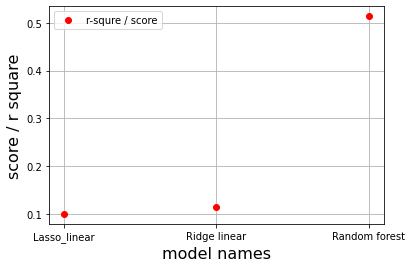

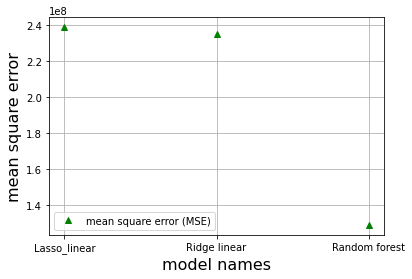

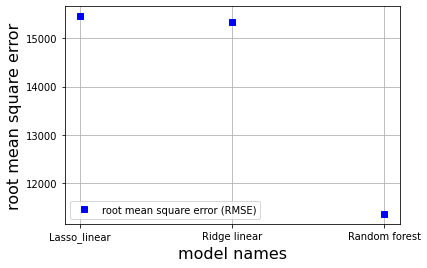

In [ ]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

## 4.3 Feature importance

According to MSE,RMSE and R square, the Random Forest Regression has the best performance

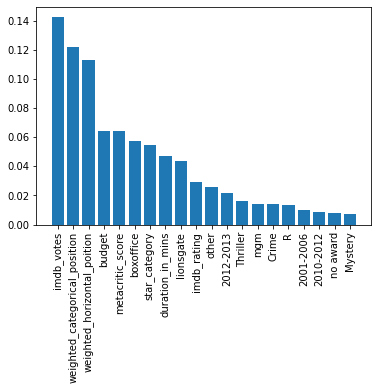

In [ ]:
importances = rf.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()